# Import Packages

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential   
from keras.layers import LSTM            
from keras.layers import Dense           
from keras.layers import Dropout   
from keras.callbacks import EarlyStopping

# Loading Dataset

In [68]:
dataset = pd.read_csv("TSLA.csv")
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


## Splitting Dataset into Train and Test set

In [69]:
split_row = len(dataset)- int(0.2 * len(dataset))
train_data = dataset.iloc[:split_row]
test_data = dataset.iloc[split_row:]
print("SHAPE OF TRAIN DATA :",train_data.shape)
print("SHAPE OF TEST DATA :",test_data.shape)

SHAPE OF TRAIN DATA : (1933, 7)
SHAPE OF TEST DATA : (483, 7)


## Load the closing value of stock

In [70]:
train_dataset = train_data.loc[:,["Close"]].values
train_dataset.shape

(1933, 1)

## Visualise Close value of Dataset

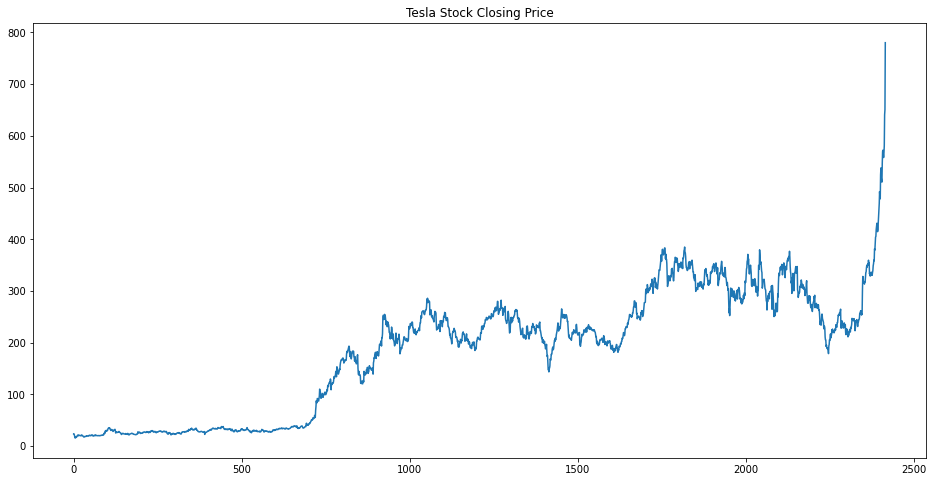

In [71]:
plt.figure(figsize=(16,8))
plt.plot(dataset["Close"])
plt.title("Tesla Stock Closing Price")
plt.show()

# Scaling Data using MinMaxScaler

In [72]:
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train_dataset)

# Creating data with Timesteps

In [73]:
def timesteps(train_data):
    time_steps= 60
    X_train = []
    y_train = []
    for i in range(60,len(train_data)):
        # append value of (i-60 :i,0) to X_train , take 60 values of the coloumn index 0 and append to the array
        X_train.append(train_data[i-time_steps : i,0])
        # append value of (i-60 :i) to y_train
        y_train.append(train_data[i,0])
    #convert to array
    X_train,y_train =np.array(X_train),np.array(y_train)     
    # reshape the array to make it 3D by adding 1 as feature
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    return X_train,y_train

X_train,y_train = timesteps(train_scaled) 

print("size of X_train",X_train.shape)
print("size of y_train",y_train.shape)

size of X_train (1873, 60, 1)
size of y_train (1873,)


# Build LSTM Model

In [74]:
regressor=Sequential()
"""return_sequences=True ; to return  the full sequence output
   input_shape: is the shape of training set
   units :is the dimension of cell in LSTM"""
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (60,1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50,return_sequences=True))
regressor.add(Dropout(0.2))
          
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
          
regressor.add(Dense(units=1))
          
regressor.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_9 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 60, 50)            20200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_11 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

# Compile the model and fit the model

In [75]:
callback = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
regressor.compile(optimizer="adam",loss="mean_squared_error")
model=regressor.fit(X_train,y_train,epochs=50,batch_size=32,validation_split=0.1,verbose=1, callbacks=[callback])

Epoch 1/50
53/53 [==============================] - 19s 173ms/step - loss: 0.0328 - val_loss: 0.0041
Epoch 2/50
53/53 [==============================] - 6s 119ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 3/50
53/53 [==============================] - 6s 116ms/step - loss: 0.0029 - val_loss: 0.0072
Epoch 4/50
53/53 [==============================] - 7s 133ms/step - loss: 0.0028 - val_loss: 0.0035
Epoch 5/50
53/53 [==============================] - 6s 117ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 6/50
53/53 [==============================] - 7s 128ms/step - loss: 0.0025 - val_loss: 0.0055
Epoch 7/50
53/53 [==============================] - 6s 116ms/step - loss: 0.0025 - val_loss: 0.0055
Epoch 8/50
53/53 [==============================] - 6s 115ms/step - loss: 0.0022 - val_loss: 0.0107
Epoch 9/50
53/53 [==============================] - 6s 116ms/step - loss: 0.0021 - val_loss: 0.0078
Epoch 10/50
53/53 [==============================] - 6s 116ms/step - loss: 0.0024 - val_loss: 0.002

## Visualising Training and Validation Loss

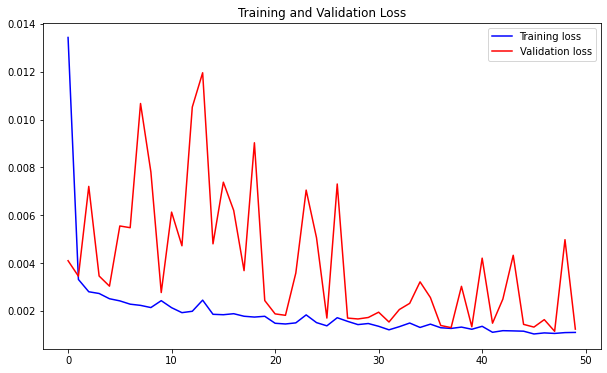

In [76]:
loss = model.history['loss']
val_loss = model.history['val_loss']
epochs = range(len(loss))
plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Testing the Model

### Merge train and test data on axis=0
### we need the 60 days’ price before the 1st date in the test dataset

In [77]:
dataset_total=(pd.concat((train_data["Close"],test_data["Close"]),axis=0))
model_input = dataset_total[len(dataset_total) - len(test_data) - 60:].values

### Reshape &  Scale the Training Data

In [78]:
model_input=model_input.reshape(-1,1)   #reshape
model_input=scaler.fit_transform(model_input)   #scale
model_input
print("SHAPE OF MODELINPUT :",model_input.shape)

SHAPE OF MODELINPUT : (543, 1)


## Creating data with Timesteps

In [79]:
time_steps= 60
X_test = []
for i in range(60,len(model_input)):
    X_test.append(model_input[i-time_steps : i,0])
    
X_test = np.array(X_test)     
# reshape the array to make it 3D by adding 1 as feature
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print("shape of X_test ",X_test.shape)

shape of X_test  (483, 60, 1)


In [80]:
#actual price of stock
actual_price=test_data.loc[:,["Close"]].values

## Predicting Stock Price using Test  Data

In [81]:
predicted_price = regressor.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price)

# Visualise Actual vs Predicted Stock Price

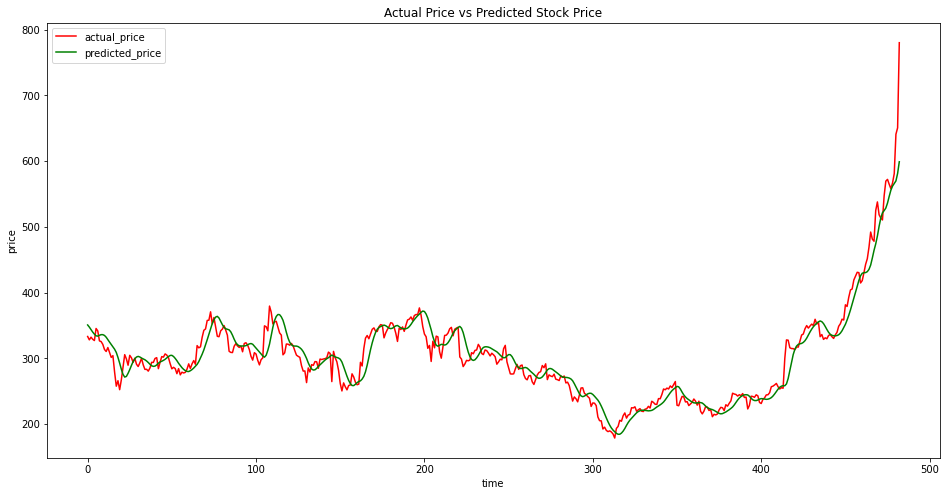

In [82]:
plt.figure(figsize=(16,8))
plt.plot(actual_price,color="red",label="actual_price")
plt.plot(predicted_price,color=("green"),label="predicted_price")
plt.title("Actual Price vs Predicted Stock Price")
plt.xlabel("time")
plt.ylabel("price")
plt.legend()
plt.show()